In [74]:
import numpy as np
import pandas as pd

from collections import ChainMap
from pathlib     import Path

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.spatial.distance import jaccard

In [2]:
def _get_time_from_session(session_file):
  session2time = {}
  
  with(open(session_file,'r')) as f:
    for line in f:
      atts = line.rstrip('\n').split(' ')
      
      session2time[int(atts[0])] = int(atts[2])
      
  return session2time

session2user = dict(ChainMap(*[ _get_time_from_session(session_file) for session_file in Path('data').glob('*_sessions.dat') ]))

# Document life

We start by looking at the lifetime of each document, which is the time delta between the first and the last appearances of a document (i.e. the first and the last time it has been recommended).

In [40]:
docs = {}

# Looping over all click files of the dataset.
for i,click_file in enumerate(Path('data').glob('*_clicks.dat')):
  _df = pd.read_csv(click_file,sep=' ',names=['session_id','item_id','rank','score','click_timestamp'])
  _df['session_time'] = _df.session_id.apply(lambda x: session2user[x])
  
  # Computing the total number of views (clicks) obtained by each document.
  doc_views = _df[_df.click_timestamp > 0]['item_id'].value_counts().to_dict()
  # Minimum and maximum timestamp for the current click file.
  _g = _df.groupby('item_id')['session_time'].agg(['min','max']).to_dict('index')
  
  recurrent_docs = (_g.keys() & docs.keys())
  for i in _g.keys():
    views = doc_views[i] if i in doc_views else 0
    # Computing maximum and minimum timestamp for documents occuring
    # in multiple click files.
    if i in recurrent_docs:
      docs[i]['min'] = np.min([_g[i]['min'],docs[i]['min']])
      docs[i]['max'] = np.max([_g[i]['max'],docs[i]['max']])
      docs[i]['views'] += views
    else:
      docs[i] = {'min': _g[i]['min'], 'max': _g[i]['max'], 'views': views}

docs_df = pd.DataFrame.from_dict(docs,orient='index')
docs_df['life_span'] = docs_df['max'] - docs_df['min']

In [21]:
print('{:.2f}% of documents have been recommended only once.'.format(100*len(docs_df[docs_df.life_span == 0])/len(docs_df)))
print('The maximum lifetime of a document in the dataset in {:.2f} hours.'.format(docs_df.life_span.max()/3600))
print('The mean lifetime of a document is {:.2f} hours, and the median is {:.2f} hours.'.format(np.mean(docs_df[docs_df.life_span > 0].life_span/3600),np.median(docs_df[docs_df.life_span > 0].life_span)/3600))

3.60% of documents have been recommended only once.
The maximum lifetime of a document in the dataset in 45.67 hours.
The mean lifetime of a document is 19.74 hours, and the median is 22.54 hours.


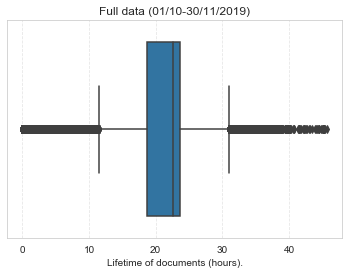

In [89]:
sns.set_style("whitegrid",{'grid.color': '.9','grid.linestyle': '--'})
ax = sns.boxplot(x=docs_df[docs_df.life_span > 0].life_span/3600)
g = ax.set(xlabel='Lifetime of documents (hours).',title='Full data (01/10-30/11/2019)')

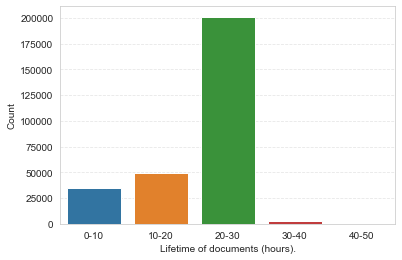

In [90]:
docs_df['binned_lifespan'] = pd.cut(docs_df[docs_df.life_span > 0].life_span/3600,[0,10,20,30,40,50],labels=['0-10','10-20','20-30','30-40','40-50'])
ax = sns.countplot(x='binned_lifespan',data=docs_df)
g = ax.set(xlabel='Lifetime of documents (hours).',ylabel='Count')

As shown on the above graphics, the lifetime of documents is quite small with an average and a median smaller than one day.
These findings emphasise the role that freshness plays in the recommendation ranking function: documents that are more than 1 day old are basically considered irrelevant for the ranking function.

This has major implications for the development of user embeddings that capture the latent preferences of the users.
Most methods rely on the observation of the same documents for multiple users, which would be problematic in our case if we consider data spanning multiple months.
Two users might be very similar in reality in the sense that they read or skip documents discussing the same topics and should then have very close user embeddings, but this similarity could not be captured due to the same document id only occurring over a small period of time.

We identified two possible solutions at this problem:
* simply avoid the problem for now and compute micro-batches of user embeddings based solely on their interactions within a single day
* use the text content of documents to compute topical similarity metrics between documents. Following a semi-supervised approach, we would then be able to compute the chances of positive (or negative) feedback for documents that are similar to the explicit feedback already recorded for each user.

For simplicity, we will start with the first approach before diving deeper.

# Document views

We quickly explore the potential relation between the absolute number of views (i.e. number of times the document has been clicked) and its lifetime.
The question we aim to answer is: Is the number of views of document a simple factor of its lifetime?

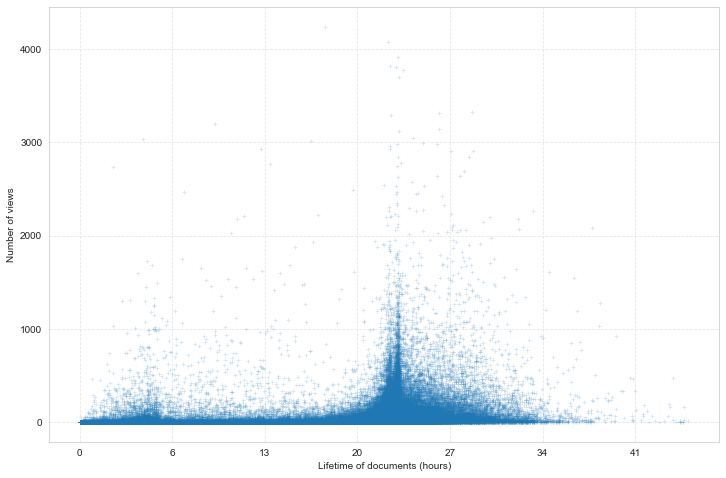

In [91]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="life_span", y="views", data=docs_df, s=12, marker='+', alpha=0.2)
xlabels = [int(x) for x in ax.get_xticks()/3600]
ax.set_xticklabels(xlabels)
g = ax.set(xlabel='Lifetime of documents (hours)',ylabel='Number of views')
#ax.set(ylim=(1, 10000),xlim=(1,300000))
#g = ax.set(yscale='log',xscale="log")

We see no general trend from the above graphics.
This suggests that users are not severely biased towards the freshness of documents, although one might argue that all documents with a lifetime < 48 hours are "fresh".

We can however observe two spikes of views: one small spike for "disposable" documents that span no more than 6 hours, and another larger one around 24 hours.
These spikes might require more investigation on why such documents get more views, but they look like artefacts from the ranking/indexing policy of the recommender system, where some documents might get removed from the index or heavily downranked when they reach these lifetimes.